# Quantify transports across Iceland-Faroe Ridge by source and destination

The idea here is to use Lagrangian particle tracks to quantify model volume transports from the North Atlantic into the Arctic seas by source. This is partly motivated by an idea of Stuart's that 'all' the water heading north between Greenland-Iceland-Shetland goes through the Rockall Trough (with the northward transport west of the Rockall Bank circulating in the subpolar gyre).

I've started with the Iceland-Faroes Ridge (IFR) section. This is partly just because I have an 'emotional attachment' to the IFR having spent my first postdoc modelling it, and partly because I figured if Stuart is wrong, the transport across the IFR is likely where it will show up.

Obviously it is easier to quantify transports across sections from the model just by straight eulerian calculation, but even if this is done over the whole boundary of a closed volume it doesn't give you the pathways through the volume. A 3D streamfunction would be another possibility but that doesn't seem straightforward.

The basic idea is that each particle tracked represents a streamtube (I have no diffusion in the tracking). The volume transport along that streamtube is constant at any point along the length and determined by the transport where it crosses IFR. This we get by a simple calculation of cross-sectional area x velocity across the section.

Particles are positioned randomly in 2D along a section from Iceland to Faroes, then the same particles are tracked backwards for 2 years for sources and forwards for 6 months for destinations.

This is done using OceanParcels tracking software and Viking20x model fields on GEOMAR servers via python Jupyter notebooks. This notebook has the analysis of the tracks, the notebook running Parcels is separate. This is currently just testing the method, how many particles might be needed for robust results, most efficient initial particle distributions, etc.

The transport quantities are at the very end. 2000 particles across the section seems to give OK results but ideally might want more - s.d. in total transport across IFR of maybe 10-20% by selecting a different random 2000 particles. Also this is just a snapshot (though using monthly means). With a few (<10) different crossing times I've seen total transports between 2 and 7 Sv, so with 2000 particles sampling errors probably small compared to variability.

The results for 2016 shown here suggest that of the 6.5 Sv crossing IFR 0.6 Sv came through Rockall Trough, with most of the rest coming north west of Rockall Bank, and about 0.5 Sv where I haven't identified the source. My initial feeling from other years is that most of the variability is in the flow from W of Rockall Bank with always around 0.5 Sv through Rockall Trough.

I haven't looked at Faroe-Shetland Channel yet, so this is only part (and probably the smaller part) of the northward flow in NE Atlantic towards Arctic.

So, here we
- load lagrangian trajectory data that has been written by OceanParcels from particle tracking in Viking20x model (currently using monthly mean fields for speed)
    - particles tracked from a section across IFR
    - random release points along section
    - tracked forward for 6 months to id destinations
    - tracked backwards for 2 years to id sources
- plot sections
- plot trajectories
- subset trajectories based on source and destination
- estimate transports

Transports associated with different pathways are estimated by assuming that each particle crossing IFR has an associated volume transport, which it maintains throughout its life, given by the 
                velocity across the section * total cross-sectional area / number of particles
So like a streamtube...    

## To do

- calculate section area properly 
- explore sensitivity to particle numbers and random seed (i.e. do I have enough particles)
- calculate true transport across section in model
- not selecting ocean particles properly near bed - partial cells
- fix time units on track plots

## Technical preamble

In [1]:
%matplotlib inline

import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.colors import ListedColormap



In [2]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})

In [3]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path("data/processed/tracks/TransportInitialTest/") 
filename_FSC = "test_forward_FSC_2016"
filename_IFR = "test_forward_IFR_2016"

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
nParticles = 4000.0


#velocity conversions on FSC (61N)

lat2metres_FSC = 60.0*1852.0
lon2metres_FSC = 60.0*1852.0*np.cos(np.radians(61.0))

sealandratio_FSC = 5591.0/20000.0
sectionAreaEW_FSC = 5.7 * 1500.0 * sealandratio_FSC * lon2metres_FSC  # very approx. mean depth x length between slopes.
sectionAreaNS_FSC = 1.87 * 1500.0 * sealandratio_FSC * lat2metres_FSC

#velocity conversions on IFR (63.5N)

lat2metres_IFR = 60.0*1852.0
lon2metres_IFR = 60.0*1852.0*np.cos(np.radians(63.5))

sealandratio_IFR = 9308.0/20000.0
sectionAreaEW_IFR = 7.0 * 700.0 * sealandratio_IFR * lon2metres_IFR  # very approx. mean depth x length between slopes.
sectionAreaNS_IFR = 2.8 * 700.0 * sealandratio_IFR * lat2metres_IFR


## Load data

## Estimate transports through FSC and IFR

In [4]:
files_tracks_FSC = (project_path / path_data_tracks ).glob(f"{filename_FSC}*.nc")
files_tracks_FSC = list(files_tracks_FSC)
files_tracks_IFR = (project_path / path_data_tracks ).glob(f"{filename_IFR}*.nc")
files_tracks_IFR = list(files_tracks_IFR)



In [5]:
transports_FSC = np.zeros(12)
print(transports_FSC)
for i in range(12):
    trackfile_FSC = files_tracks_FSC[i]
    ds = xr.open_dataset(trackfile_FSC)
    transports_FSC[i] = ((sectionAreaEW_FSC*ds.isel(obs=0).vvel*lat2metres_FSC +
                            sectionAreaNS_FSC*ds.isel(obs=0).uvel*lon2metres_FSC)/nParticles).sum().data
print(transports_FSC)

transports_IFR = np.zeros(12)
print(transports_IFR)
for i in range(12):
    trackfile_IFR = files_tracks_IFR[i]
    ds = xr.open_dataset(trackfile_IFR)
    transports_IFR[i] = ((sectionAreaEW_IFR*ds.isel(obs=0).vvel*lat2metres_IFR +
                            sectionAreaNS_IFR*ds.isel(obs=0).uvel*lon2metres_IFR)/nParticles).sum().data
print(transports_IFR)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2327511.     1957488.     1486008.375   647661.3125 1109718.
  478956.8125  926419.125  1876687.25   3509048.75   2101774.5
 2656195.75   3903804.5   ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2192955.75 3571794.   2475767.   2691522.5  3047330.   2620741.5
 2568685.25 2137370.25 2961764.75 2049264.   2350521.75 3092208.5 ]


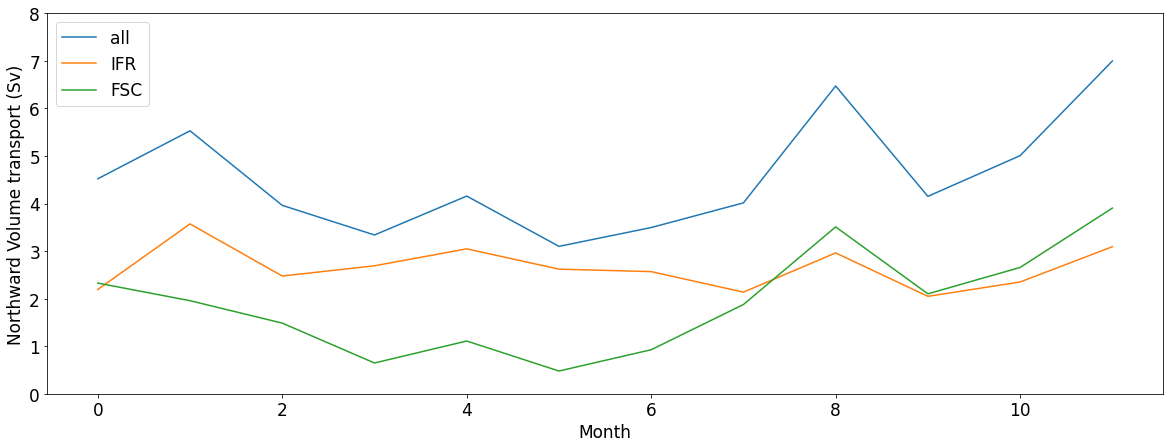

In [6]:
plt.plot((transports_IFR + transports_FSC)/1000000.0,label = 'all')
plt.plot(transports_IFR/1000000.0,label = 'IFR')
plt.plot(transports_FSC/1000000.0,label = 'FSC')
plt.ylabel("Northward Volume transport (Sv)")
plt.xlabel("Month")
plt.ylim(0,8)
plt.legend();
